<a href="https://colab.research.google.com/github/ASHIKAMOHAN/Sales_Forecasting/blob/main/Salesfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from datetime import timedelta

In [4]:
# Load and preprocess cleaned data
df = pd.read_csv('/content/drive/MyDrive/ML Data 3.csv')
df.columns = df.columns.str.strip()
df.columns.values[4] = 'Currency Type'
df.columns.values[5] = 'Txn Type'
df['Txn Type'] = df['Txn Type'].astype(str).str.strip()
df = df[df['Txn Type'] == 'S']
df['DealDate'] = pd.to_datetime(df['DealDate'], dayfirst=True)
df.rename(columns={'Reatils rate': 'ReatilsRate'}, inplace=True)



In [30]:
# Load UK bank holidays
holidays_df = pd.read_excel('/content/drive/MyDrive/ukbankholidays-jul19.xls', sheet_name='UK Bank Hols', header=None, skiprows=1)
holidays_df.columns = ['HolidayDate']
holidays_df['HolidayDate'] = pd.to_datetime(holidays_df['HolidayDate'], dayfirst=True)


In [7]:
# Step 2: Aggregate data
currency_sales = df.groupby(['DealDate', 'Location ID', 'Currency']).agg(
    SalesGBP=('Value', 'sum'),
    Amount=('Amount', 'sum'),
    ReatilsRate=('ReatilsRate', 'mean'),
    TxnCount=('Value', 'count')
).reset_index()

In [8]:
# Step 3: Feature Engineering
currency_sales['dayofweek'] = currency_sales['DealDate'].dt.dayofweek
currency_sales['month'] = currency_sales['DealDate'].dt.month
currency_sales['year'] = currency_sales['DealDate'].dt.year
currency_sales['quarter'] = currency_sales['DealDate'].dt.quarter
currency_sales['weekofyear'] = currency_sales['DealDate'].dt.isocalendar().week
currency_sales['is_weekend'] = currency_sales['dayofweek'].isin([5, 6]).astype(int)

# Add holiday features
currency_sales['is_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate']).astype(int)
currency_sales['is_day_before_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate'] - pd.Timedelta(days=1)).astype(int)
currency_sales['is_day_after_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate'] + pd.Timedelta(days=1)).astype(int)

# Lag and rolling features
currency_sales['lag_1'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(1)
currency_sales['lag_3'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(3)
currency_sales['rolling_mean_7'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(1).rolling(7).mean()
currency_sales['rolling_std_7'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(1).rolling(7).std()
currency_sales.dropna(inplace=True)

# Add holiday indicators to main dataset
currency_sales['is_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate']).astype(int)
currency_sales['is_day_before_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate'] - pd.Timedelta(days=1)).astype(int)
currency_sales['is_day_after_holiday'] = currency_sales['DealDate'].isin(holidays_df['HolidayDate'] + pd.Timedelta(days=1)).astype(int)

In [9]:
currency_sales['CurrencyLabel'] = currency_sales['Currency']
currency_sales_encoded = pd.get_dummies(currency_sales, columns=['Currency'], drop_first=True)

In [10]:
# Step 4: Train/Test Split and Model Training
features = [col for col in currency_sales_encoded.columns if col not in ['DealDate', 'SalesGBP', 'CurrencyLabel', 'Amount', 'ReatilsRate']]
X = currency_sales_encoded[features]
y = np.log1p(currency_sales_encoded['SalesGBP'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
params = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'subsample': [1],
    'colsample_bytree': [1]
}

grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
xgb_model = grid.best_estimator_

In [15]:
import joblib

# Save the model to a file
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [16]:
# Load the model from the file
xgb_model = joblib.load('xgb_model.pkl')

In [31]:
# Step 5: Predict and Compare
y_pred = np.expm1(xgb_model.predict(X_test))
y_actual = np.expm1(y_test)

sales_test = pd.DataFrame({
    'Actual SalesGBP': y_actual,
    'Predicted SalesGBP': y_pred
}, index=y_test.index)

sales_test = sales_test.join(currency_sales[['DealDate', 'Location ID', 'CurrencyLabel', 'Amount', 'ReatilsRate']], how='left')
sales_test['Predicted Amount'] = sales_test['Predicted SalesGBP'] * sales_test['ReatilsRate']
sales_test['Predicted Currency Value'] = sales_test['Predicted SalesGBP'] / sales_test['ReatilsRate']
sales_test['Difference'] = sales_test['Actual SalesGBP'] - sales_test['Predicted SalesGBP']


In [32]:
# Step 6: Evaluate
mae = mean_absolute_error(sales_test['Actual SalesGBP'], sales_test['Predicted SalesGBP'])
rmse = np.sqrt(mean_squared_error(sales_test['Actual SalesGBP'], sales_test['Predicted SalesGBP']))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 521.00
RMSE: 2039.74


In [33]:
# Step 7: Filter Top 15 Branch-Currency Combinations
top_pairs = sales_test.groupby(['Location ID', 'CurrencyLabel'])['Actual SalesGBP'].sum().nlargest(15).reset_index()


In [34]:
# Step 8: Forecast for Next 7 Days
future_dates = pd.date_range(start=currency_sales['DealDate'].max() + timedelta(days=1), periods=7)
forecast_records = []
for _, row in top_pairs.iterrows():
    branch = row['Location ID']
    currency = row['CurrencyLabel']
    recent = currency_sales[(currency_sales['Location ID'] == branch) & (currency_sales['CurrencyLabel'] == currency)].sort_values('DealDate').tail(7)
    if recent.empty:
        continue
    for date in future_dates:
        features = {
            'dayofweek': date.dayofweek,
            'month': date.month,
            'year': date.year,
            'quarter': date.quarter,
            'weekofyear': date.isocalendar().week,
            'is_weekend': int(date.dayofweek in [5, 6]),
            'lag_1': recent['SalesGBP'].iloc[-1],
            'lag_3': recent['SalesGBP'].iloc[-3] if len(recent) >= 3 else recent['SalesGBP'].iloc[-1],
            'rolling_mean_7': recent['SalesGBP'].mean(),
            'rolling_std_7': recent['SalesGBP'].std(),
            'expanding_mean': recent['SalesGBP'].expanding().mean().iloc[-1],
            'Amount': recent['Amount'].mean(),
            'ReatilsRate': recent['ReatilsRate'].mean(),
            'TxnCount': recent['TxnCount'].mean(),
            'is_holiday': int(date in holidays_df['HolidayDate'].values),
            'is_day_before_holiday': int((date + pd.Timedelta(days=1)) in holidays_df['HolidayDate'].values),
            'is_day_after_holiday': int((date - pd.Timedelta(days=1)) in holidays_df['HolidayDate'].values)
        }
        for cur in df['Currency'].unique():
            features[f'Currency_{cur}'] = 1 if cur == currency else 0
        input_df = pd.DataFrame([features])
        input_df = input_df.reindex(columns=X.columns, fill_value=0)
        pred_gbp = np.expm1(xgb_model.predict(input_df)[0])
        pred_amt = pred_gbp * features['ReatilsRate']
        forecast_records.append({
            'DealDate': date,
            'Location ID': branch,
            'Currency': currency,
            'Forecasted SalesGBP': round(pred_gbp, 2),
            'Forecasted Amount': round(pred_amt, 2),
            'Forecasted SalesInCurrency': round(pred_gbp / features['ReatilsRate'], 2),
            'Retail Rate': round(features['ReatilsRate'], 4)
        })

In [35]:
# Identify and print top 10 branches
top_branches = sales_test.groupby('Location ID')['Actual SalesGBP'].sum().nlargest(15)
print("Top 10 Branches by Actual SalesGBP:")
print(top_branches)

# Identify and print top 10 currencies
top_currencies = sales_test.groupby('CurrencyLabel')['Actual SalesGBP'].sum().nlargest(30)
print("\nTop 10 Currencies by Actual SalesGBP:")
print(top_currencies)

Top 10 Branches by Actual SalesGBP:
Location ID
140    40320708.36
65      8070568.71
113     4704289.60
28      4263647.01
59      4171371.66
75      4132540.38
84      4083693.95
132     4000951.37
116     3912901.14
134     3867356.86
58      3601363.40
73      3541519.89
186     3385449.14
160     3353504.31
107     3284280.64
Name: Actual SalesGBP, dtype: float64

Top 10 Currencies by Actual SalesGBP:
CurrencyLabel
EUR    2.759862e+08
USD    6.249956e+07
TRY    1.447561e+07
AED    6.073504e+06
THB    5.910147e+06
AUD    5.079067e+06
GBP    4.677715e+06
CAD    4.011330e+06
PLN    3.570939e+06
MXN    2.841103e+06
CZK    2.795821e+06
JPY    2.660869e+06
EGP    2.274153e+06
HUF    1.952081e+06
BGN    1.814910e+06
ZAR    1.797346e+06
CHF    1.596506e+06
HRK    1.514185e+06
MAD    1.444714e+06
IDR    1.255709e+06
SAR    1.046358e+06
ISK    9.656608e+05
NZD    9.123389e+05
BBD    8.875364e+05
VND    8.676623e+05
NOK    8.179768e+05
DKK    7.872839e+05
JMD    5.893027e+05
SGD    5.194244e

In [36]:
sales_test = pd.DataFrame({
    'Actual SalesGBP': y_actual,
    'Predicted SalesGBP': y_pred
}, index=y_test.index)

# Join the necessary columns for context
sales_test = sales_test.join(currency_sales[['DealDate', 'Location ID', 'CurrencyLabel', 'Amount', 'ReatilsRate']], how='left')

# Compute predicted amount in original currency and the difference
sales_test['Predicted Amount'] = sales_test['Predicted SalesGBP'] * sales_test['ReatilsRate']
sales_test['Difference'] = sales_test['Actual SalesGBP'] - sales_test['Predicted SalesGBP']

In [37]:
print("Actual vs Predicted Sales for Test Set (sample):")
print(sales_test[['DealDate', 'Location ID', 'CurrencyLabel', 'Actual SalesGBP', 'Predicted SalesGBP', 'Difference']].head(15))

Actual vs Predicted Sales for Test Set (sample):
          DealDate  Location ID CurrencyLabel  Actual SalesGBP  \
520652  2023-05-23          133           EUR          4244.84   
221832  2022-08-29          183           EUR          4885.31   
1159077 2024-09-09           95           EUR          3783.10   
540442  2023-06-08           58           USD           441.16   
697182  2023-10-08          111           EGP           423.24   
850359  2024-02-03           12           AUD          1001.01   
782752  2023-12-12          152           CHF           499.58   
213853  2022-08-22          140           CZK          1831.45   
1119286 2024-08-13          131           THB           504.08   
1346240 2025-01-23           84           IDR           152.50   
253521  2022-09-26           38           CZK           118.71   
374138  2023-01-15           30           TRY           119.88   
128354  2022-06-06          142           EUR          6656.12   
645887  2023-08-30         

In [38]:
# Step 9: Output
forecast_df = pd.DataFrame(forecast_records)
forecast_df.to_csv('forecast_top15_branch_currency.csv', index=False)
print(forecast_df.head(15))

     DealDate  Location ID Currency  Forecasted SalesGBP  Forecasted Amount  \
0  2025-05-01          140      EUR         96742.031250          110617.19   
1  2025-05-02          140      EUR         93712.640625          107153.31   
2  2025-05-03          140      EUR         92796.882812          106106.20   
3  2025-05-04          140      EUR         74193.476562           84834.63   
4  2025-05-05          140      EUR        101420.898438          115967.12   
5  2025-05-06          140      EUR         98237.882812          112327.57   
6  2025-05-07          140      EUR         98945.882812          113137.11   
7  2025-05-01           65      EUR         50474.558594           56451.99   
8  2025-05-02           65      EUR         48893.980469           54684.23   
9  2025-05-03           65      EUR         48416.179688           54149.85   
10 2025-05-04           65      EUR         41432.679688           46339.33   
11 2025-05-05           65      EUR         52915.76

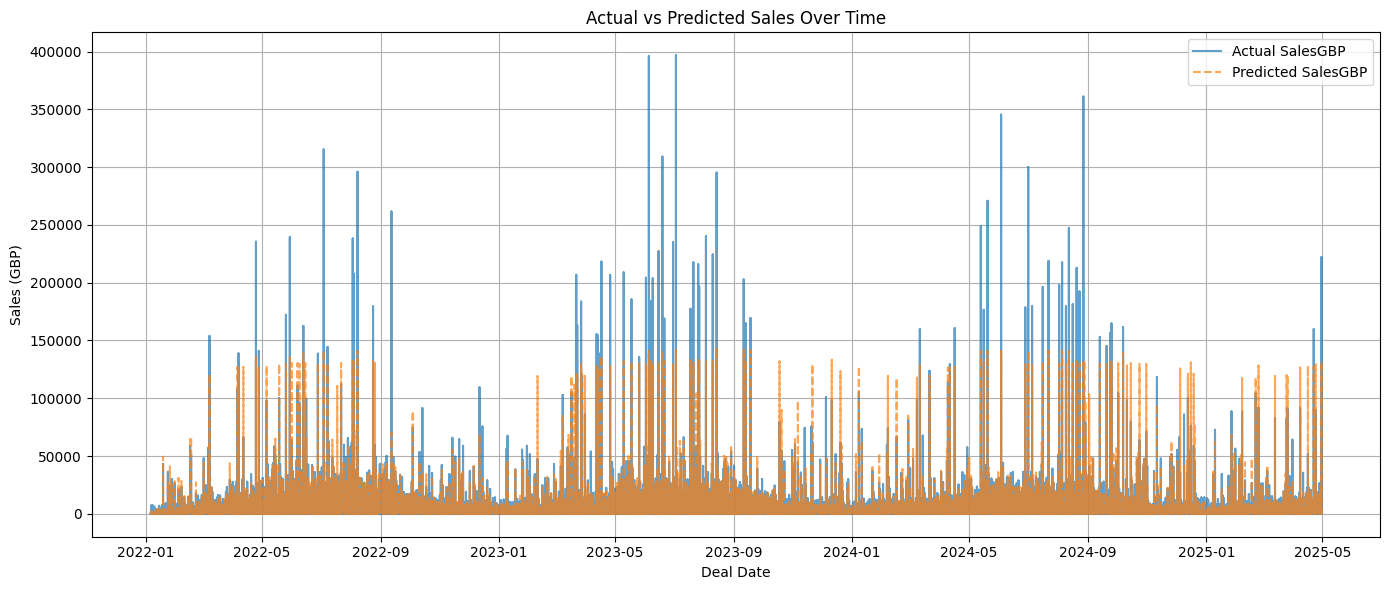

In [39]:
import matplotlib.pyplot as plt

# Sort by DealDate for proper time sequence
sales_test_sorted = sales_test.sort_values(by='DealDate')

# Line chart
plt.figure(figsize=(14, 6))
plt.plot(sales_test_sorted['DealDate'], sales_test_sorted['Actual SalesGBP'], label='Actual SalesGBP', linestyle='-', alpha=0.7)
plt.plot(sales_test_sorted['DealDate'], sales_test_sorted['Predicted SalesGBP'], label='Predicted SalesGBP', linestyle='--', alpha=0.7)
plt.xlabel('Deal Date')
plt.ylabel('Sales (GBP)')
plt.title('Actual vs Predicted Sales Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

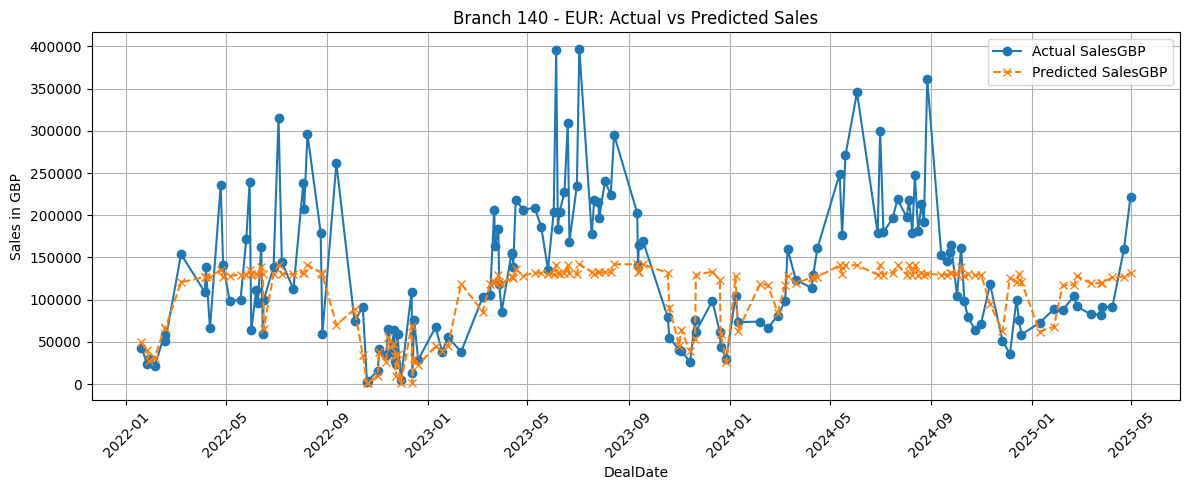

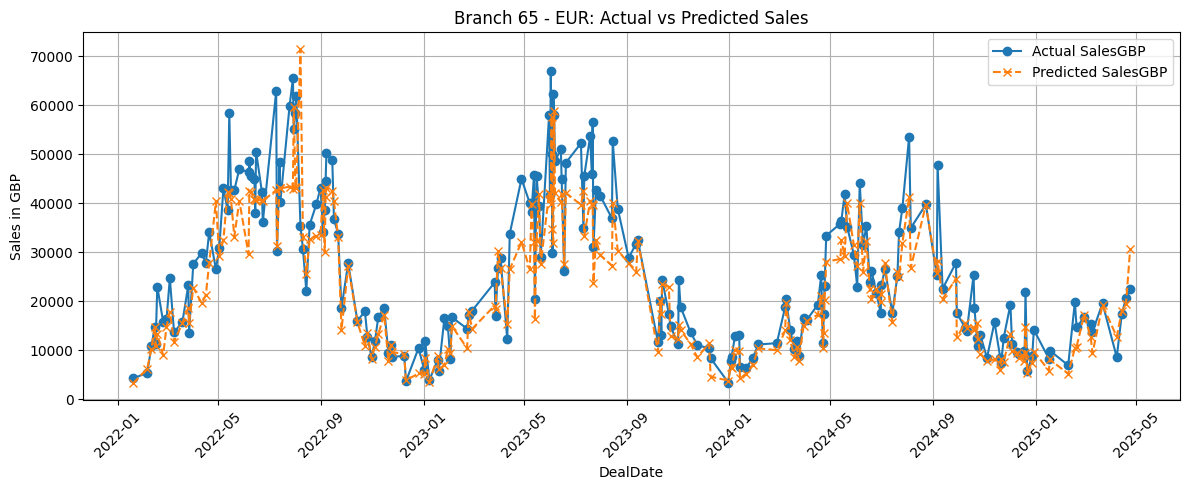

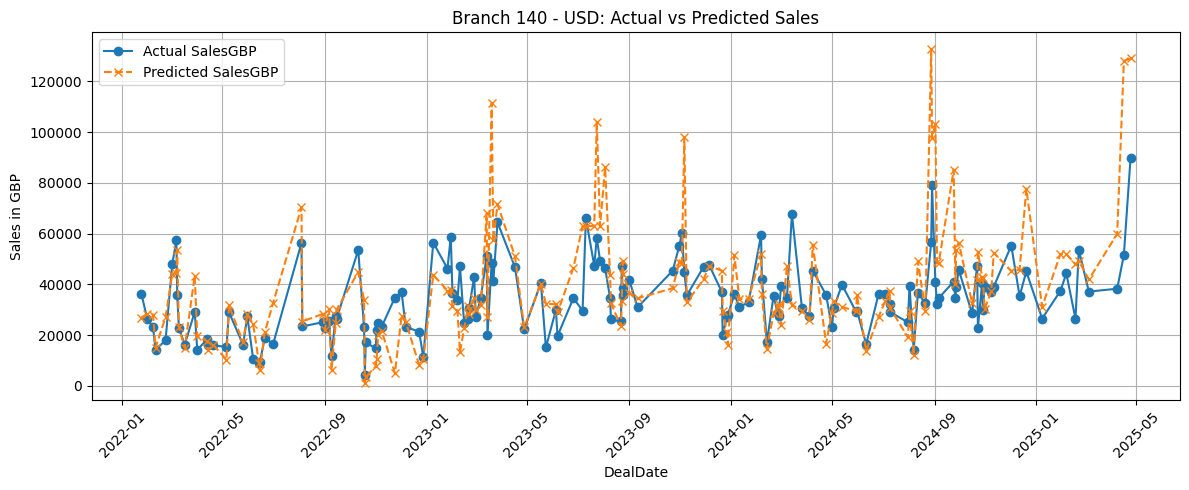

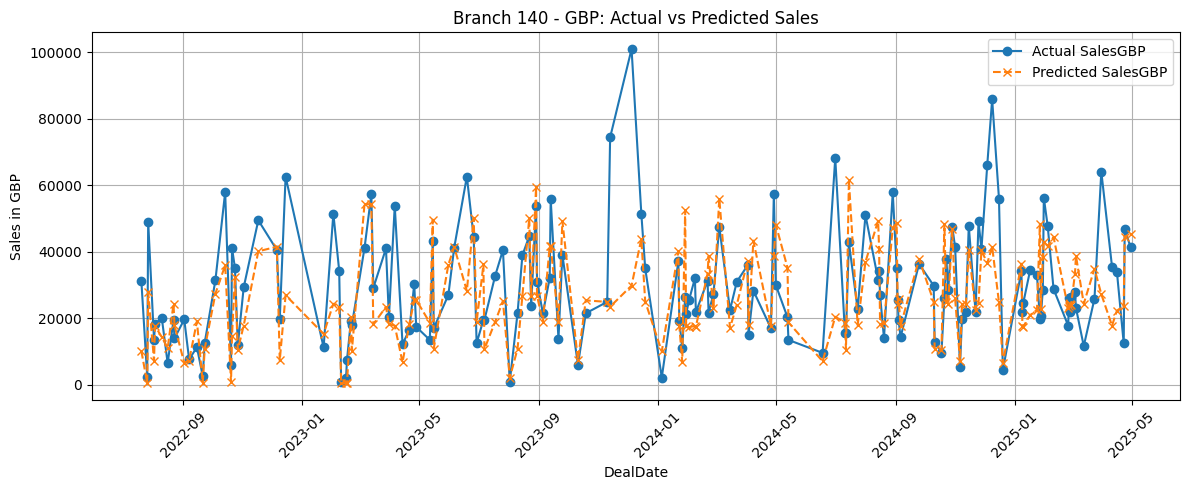

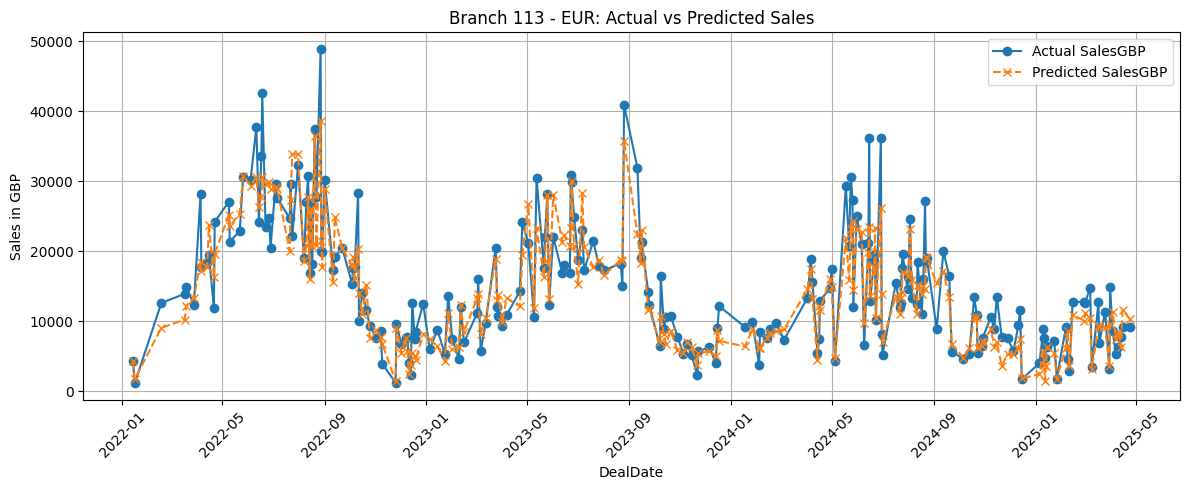

In [27]:
import matplotlib.pyplot as plt

# Identify top 5 (Location ID, CurrencyLabel) pairs by total sales
top_pairs = sales_test.groupby(['Location ID', 'CurrencyLabel'])['Actual SalesGBP'].sum().nlargest(5).reset_index()

# Plot for each pair
for _, row in top_pairs.iterrows():
    loc = row['Location ID']
    curr = row['CurrencyLabel']

    pair_data = sales_test[(sales_test['Location ID'] == loc) & (sales_test['CurrencyLabel'] == curr)]
    pair_data = pair_data.sort_values('DealDate')  # Sort by date

    plt.figure(figsize=(12, 5))
    plt.plot(pair_data['DealDate'], pair_data['Actual SalesGBP'], label='Actual SalesGBP', marker='o')
    plt.plot(pair_data['DealDate'], pair_data['Predicted SalesGBP'], label='Predicted SalesGBP', marker='x', linestyle='--')
    plt.title(f'Branch {loc} - {curr}: Actual vs Predicted Sales')
    plt.xlabel('DealDate')
    plt.ylabel('Sales in GBP')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()